In [25]:
#pip install gymnasium

In [26]:
import gym  # Import biblioteki do środowiska gier
import math  # Import matematycznej biblioteki Pythona
import random  # Import biblioteki do generowania liczb losowych
import matplotlib  # Import biblioteki do rysowania wykresów
import matplotlib.pyplot as plt  # Import modułu do tworzenia wykresów z matplotlib
from collections import namedtuple, deque  # Import bibliotek do kolekcji danych
from itertools import count  # Import modułu do iteracji po sekwencjach

import torch  # Import biblioteki PyTorch do uczenia maszynowego
import torch.nn as nn  # Import modułu do tworzenia sieci neuronowych w PyTorch
import torch.optim as optim  # Import modułu do optymalizacji w PyTorch
import torch.nn.functional as F  # Import modułu do funkcji aktywacji w PyTorch

env = gym.make("CartPole-v1")  # Tworzenie środowiska gry "CartPole-v1"

# Ustawienie matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()  # Włączenie trybu interaktywnego dla matplotlib

# Użycie GPU, jeśli jest dostępne
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [27]:
# Tworzenie nazwanego krotki o nazwie 'Transition' z polami 'state', 'action', 'next_state' i 'reward'
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        # Inicjalizacja pamięci jako kolejki o maksymalnej pojemności 'capacity'
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Zapisuje przejście do pamięci"""
        # Dodawanie nowego przejścia do pamięci, przekształcając argumenty w obiekt typu 'Transition'
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        # Losowe próbkowanie 'batch_size' przejść z pamięci
        return random.sample(self.memory, batch_size)

    def __len__(self):
        # Zwraca aktualną liczbę elementów w pamięci
        return(len(self.memory))


In [28]:
# Definicja klasy DQN (Deep Q-Network) reprezentującej model sieci neuronowej
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        # Warstwa liniowa (fully connected) o rozmiarze 'n_observations' (wejście) do 128 neuronów
        self.layer1 = nn.Linear(n_observations, 128)
        # Kolejna warstwa liniowa z 128 neuronami do 128 neuronów
        self.layer2 = nn.Linear(128, 128)
        # Warstwa liniowa z 128 neuronami na 'n_actions' neuronów (wyjście)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        # Przekazanie danych przez warstwy z funkcją aktywacji ReLU
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        # Zwrócenie wyniku z ostatniej warstwy liniowej (bez funkcji aktywacji)
        return self.layer3(x)


In [29]:
# Hiperparametry uczenia i konfiguracja
BATCH_SIZE = 128  # Rozmiar batcha
GAMMA = 0.99  # Współczynnik dyskontowania przyszłych nagród
EPS_START = 0.9  # Początkowa wartość ε (epsilon) w ε-greedy exploration
EPS_END = 0.05  # Końcowa wartość ε (epsilon)
EPS_DECAY = 1000  # Tempo spadku ε w procesie eksploracji
TAU = 0.005  # Współczynnik zmiękczenia dla modelu docelowego (soft target update)
LR = 1e-4  # Współczynnik szybkości uczenia

# Pobranie liczby dostępnych akcji z przestrzeni akcji środowiska
n_actions = env.action_space.n
# Pobranie liczby obserwacji stanu
state, info = env.reset()
n_observations = len(state)

# Inicjalizacja modelu policy_net i target_net
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

# Inicjalizacja optymalizatora
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# Inicjalizacja pamięci powtórek
memory = ReplayMemory(10000)

# Inicjalizacja licznika kroków
steps_done = 0

# Funkcja select_action dokonuje wyboru akcji w procesie eksploracji
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # Wybór akcji na podstawie maksymalnej oczekiwanej nagrody
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # Losowy wybór akcji w celu eksploracji
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

# Lista przechowująca długości epizodów
episode_durations = []

# Funkcja do wizualizacji przebiegu uczenia
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    
    # Wyświetlenie średnich długości epizodów w oknie
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # Pauza, aby wykresy były aktualizowane
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


In [30]:
# Optymalizacja modelu poprzez aktualizację wag sieci neuronowej
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return  # Jeśli pamięć nie zawiera wystarczająco dużo przejść, to nie optymalizujemy modelu

    # Próbkowanie BATCH_SIZE przejść z pamięci
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Utworzenie maski dla stanów końcowych (czy nie są None)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)

    # Utworzenie tensora zawierającego stany, akcje i nagrody z danego batcha przejść
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Obliczenie wartości stanu-akcji dla stanów w batchu
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Inicjalizacja tensora next_state_values zerami
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    # Obliczenie oczekiwanych wartości stanu-akcji dla stanów niekońcowych
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    # Wyliczenie spodziewanych wartości stanu-akcji z wykorzystaniem równania Bellmana
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Definicja funkcji straty - użycie funkcji straty Smooth L1
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Wyzerowanie gradientów, obliczenie gradientów i aktualizacja wag sieci
    optimizer.zero_grad()
    loss.backward()

    # Ograniczenie wartości gradientów do uniknięcia eksplozji gradientów
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)

    # Aktualizacja wag sieci na podstawie obliczonych gradientów
    optimizer.step()


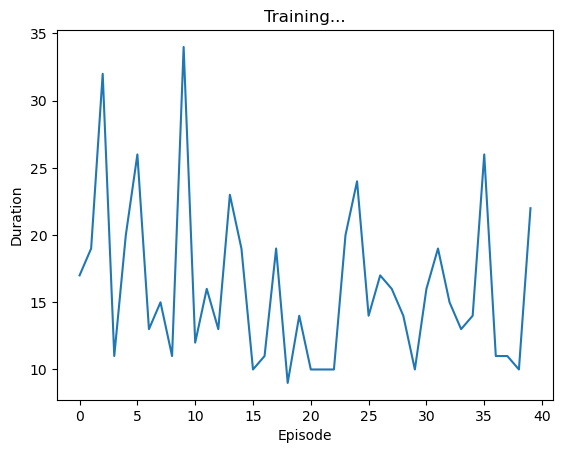

<Figure size 640x480 with 0 Axes>

In [31]:
# Sprawdzenie dostępności GPU (jeśli dostępne, zwiększamy liczbę epizodów)
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

# Pętla główna - przechodzi przez określoną liczbę epizodów
for i_episode in range(num_episodes):
    # Inicjalizacja środowiska i pobranie stanu
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Zapisanie przejścia do pamięci powtórek
        memory.push(state, action, next_state, reward)

        # Przejście do następnego stanu
        state = next_state

        # Wykonanie jednego kroku optymalizacji (na sieci polityki)
        optimize_model()

        # Aktualizacja wag sieci docelowej z wykorzystaniem twardego uaktualnienia
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Ukończono')
plot_durations(show_result=True)
plt.ioff()
plt.show()
